In [790]:
%matplotlib widget
import geopandas as gpd
import os
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from adjustText import adjust_text
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import variogram_tools
from itertools import combinations_with_replacement
from scipy.special import kv, gamma
from scipy.optimize import curve_fit
import pandas as pd

import folium
from folium import features, plugins
from shapely.geometry import shape, Polygon, LineString, Point
from pyproj import Transformer


import json

from ipyleaflet import Map, DrawControl,ImageOverlay
from shapely.geometry import shape

from osgeo import gdal

import rasterio
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import rasterio
from rasterio.transform import from_origin

from itertools import combinations_with_replacement
from scipy.special import kv, gamma
import numpy as np
from scipy.optimize import curve_fit
import rioxarray as rio

import rasterio
from rasterio.mask import mask
import os
from shapely.geometry import mapping

import rasterio
import numpy as np
from scipy.stats import median_abs_deviation
from rasterio.enums import Resampling



## Table of Contents
- [Introduction](#introduction)
- [Define stable areas](#define-stable-areas)
  - [Draw profiles and stable areas on interactive map](#draw-profiles-and-stable-areas-on-interactive-map)
  - [Import shapefiles](#import-shapefiles)
- [Features](#features)
  - [Feature 1](#feature-1)
  - [Feature 2](#feature-2)
- [Usage](#usage)
- [Contributing](#contributing)
- [License](#license)

# Introduction

This notebook walks us through

# Define stable areas

## Draw profiles and stable areas on interactive map

In [ ]:
data_path="test_data/"

In [ ]:
# Load the TIF file
with rasterio.open(data_path+"topo_diff.tif") as dataset:
    # Read the raster data
    img = dataset.read(1)  # Read the first band

    # Get the bounds of the raster data in UTM
    bounds = dataset.bounds
    crs = dataset.crs

    # Create a transformer to convert from UTM to WGS84
    transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)

    # Transform the bounds to lat/lon
    west, south = transformer.transform(bounds.left, bounds.bottom)
    east, north = transformer.transform(bounds.right, bounds.top)


# Map setup
m = Map(center=((north + south) / 2, (west + east) / 2), zoom=15, layout={'height':'800px', 'width':'1300px'})
draw_control = DrawControl()
draw_control.polyline = {"shapeOptions": {"color": "#6bc2e5", "weight": 8}}
draw_control.polygon = {"shapeOptions": {"fillColor": "#fca45d", "color": "#de8f05", "fillOpacity": 0.5}}
draw_control.rectangle = {"shapeOptions": {"fillColor": "#fca45d", "color": "#de8f05", "fillOpacity": 0.5}}
m.add_control(draw_control)

# Store Shapely objects
shapely_geometries = []

# Handler for drawn shapes
def handle_draw(target, action, geo_json):
    geom = shape(geo_json['geometry'])
    shapely_geometries.append(geom)
    print("Added shape:", geom)
    print("Number of shapes stored:", len(shapely_geometries))

draw_control.on_draw(handle_draw)

#Create an image overlay
overlay = ImageOverlay(
    url=data_path+"topo_diff.png",  # Path to the image file created from the raster data
    bounds=((south, west), (north, east))
)

# Add the overlay to the map
m.add_layer(overlay)

# Display map
m



Map(center=[43.60345346429935, -110.6854502479764], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
shapely_geometries

[<POLYGON ((-110.705 43.614, -110.706 43.593, -110.705 43.593, -110.705 43.59...>,
 <LINESTRING (-110.698 43.598, -110.697 43.599, -110.697 43.599, -110.697 43....>]

In [242]:
polygon_list = [geom for geom in shapely_geometries if isinstance(geom, Polygon)]
linestring_list = [geom for geom in shapely_geometries if isinstance(geom, LineString)]

stable_areas={}
for i,polygon in enumerate(polygon_list):
    gdf = gpd.GeoDataFrame({'geometry': [polygon]})
    gdf.set_crs("EPSG:4326", inplace=True)
    gdf=gdf.to_crs(crs)
    key = f"stable{i+1}"
    stable_areas[key] = gdf 

profiles={}
for i,line in enumerate(linestring_list):
    gdf = gpd.GeoDataFrame({'geometry': [line]})
    gdf.set_crs("EPSG:4326", inplace=True)
    gdf=gdf.to_crs(crs)
    key = f"profile{i+1}"
    profiles[key] = gdf 

## Import shapefiles

### Functions

In [181]:
def load_shapefiles(data_path, prefix, shp_number):
    """
    Load multiple shapefiles into a dictionary of GeoDataFrames.

    Parameters:
    - data_path (str): The path to the directory with the shapefiles.
    - prefix (str): The prefix (before the number) in the filenames giving the shapefile type.
    - shp_number (int): The number of shapefiles of that type to search for.

    Returns:
    - dict: A dictionary where keys are simplified filenames and values are GeoDataFrames.
    """
    gdfs = {}
    for i in range(1, shp_number + 1):  # Corrected to include shp_number
        filename = f"{prefix}{i}.shp"
        file_path = os.path.join(data_path, filename)  # Correct path construction
        if os.path.exists(file_path):
            key = f"{prefix}{i}"
            gdfs[key] = gpd.read_file(file_path)
        else:
            print(f"No file found at path: {file_path}")
    return gdfs

### Load shapefiles of profiles and stable areas

In [182]:
profiles = load_shapefiles(data_path, "profile", 2)
stable_areas = load_shapefiles(data_path, "stable", 4)

### Plot

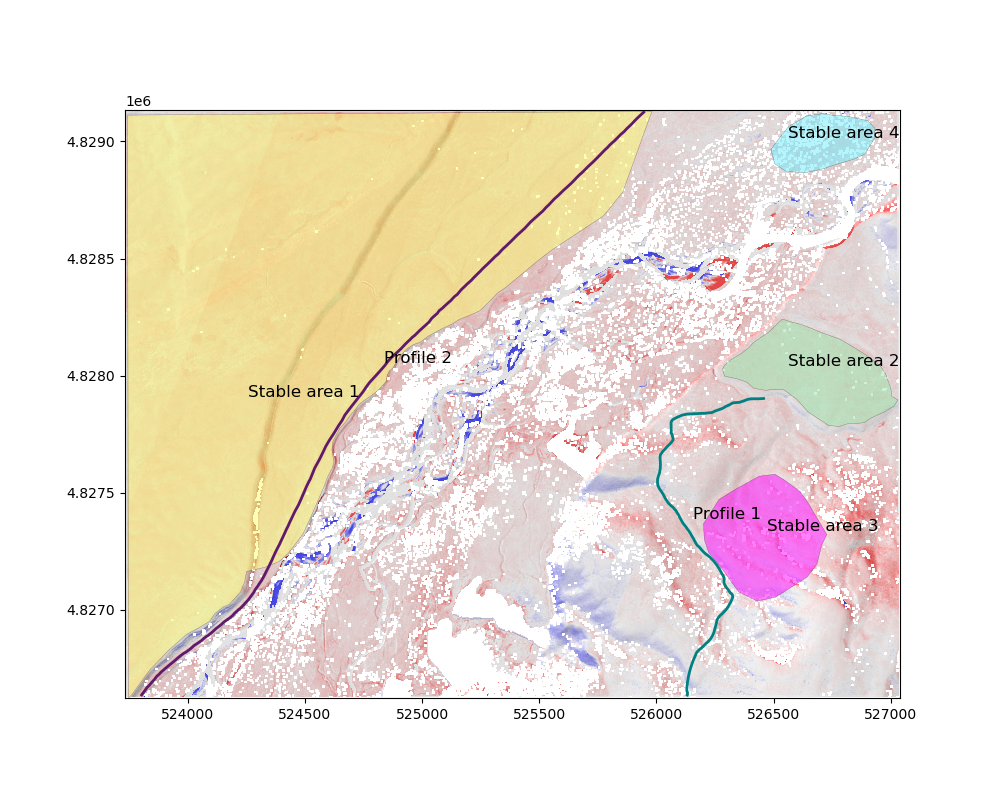

In [183]:
# Load topographic and hillshade raster data
diff_path = data_path + "topo_diff.tif"
hillshade_path = data_path + "hillshade_dtm_compare.tif"

with rasterio.open(diff_path) as diff:
    topo_diff = diff.read(1, masked=True)
    diff_extent = [diff.bounds.left, diff.bounds.right, diff.bounds.bottom, diff.bounds.top]
    topo_diff_mask = np.ma.getmask(topo_diff)  # Extract mask from topo_diff
    topo_mask = diff.read_masks(1)
    
with rasterio.open(hillshade_path) as data:
    hillshade = data.read(1, masked=True)
    hill_mask = data.read_masks(1) 

# Combine the masks from both datasets
combined_mask = np.logical_not(np.logical_and(topo_mask, hill_mask))

# Apply the combined mask to both datasets
topo_diff = np.ma.masked_where(combined_mask, topo_diff, np.nan)
hillshade = np.ma.masked_where(combined_mask, hillshade, np.nan)

# Define figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the topographic differencing with colormap
vmin, vmax = -0.5, 0.5 # Define your own min and max based on your data range
cmap_diff = plt.get_cmap('bwr_r')
cmap_diff.set_bad(color='none')
norm = Normalize(vmin=vmin, vmax=vmax)
ax.imshow(topo_diff, cmap=cmap_diff, norm=norm, extent=diff_extent)

# Overlay the hillshade with the differencing results as a transparency layer
cmap_shade = plt.get_cmap('gray')
cmap_shade.set_bad(color='none')
ax.imshow(hillshade, cmap=cmap_shade, alpha=0.4, extent=diff_extent)

# Initialize list for adjust_text
texts = []

# Plot profiles and label them
profile_colors = ["teal", "#5f1b6b", "sienna"]
for i, profile in enumerate(profiles):
    gdf = profiles[profile]
    gdf.plot(ax=ax, color=profile_colors[i], linewidth=2)  # Use same ax
    label = f"Profile {i+1}"
    x, y = np.median(gdf['geometry'][0].xy[0]), np.median(gdf['geometry'][0].xy[1])
    texts.append(plt.text(x, y, label, fontsize=12, color='k'))  

# Plot stable areas and label them
stable_area_colors = ["#fffe71", "#9be5aa", "fuchsia", "#6dedfd"]
for i, stable in enumerate(stable_areas):
    gdf = stable_areas[stable]
    gdf.plot(ax=ax, color=stable_area_colors[i], alpha=0.5, edgecolor='black', linewidth=0.25)  # Use same ax
    label = f"Stable area {i+1}"
    x, y = gdf['geometry'].representative_point().x[0], gdf['geometry'].representative_point().y[0]
    texts.append(plt.text(x, y, label, fontsize=12, color='k'))  

adjust_text(texts, ax=ax, expand_points=(1.2, 1.2), expand_text=(1.1, 1.1),
            force_text=(0.5, 0.5), force_points=(0.5, 0.5),
            autoalign='y', only_move={'points':'y', 'text':'y', 'objects':'y'})

# Display the plot
plt.show()

# Examine spatial stationarity

#### Functions

In [665]:
def crop_to_poly(input_raster,gdfs,output_raster):
    if not gdfs:  # This checks if the dictionary is empty
        print("No features in dictionary, rasters were not cropped.")
    else:
        # Export the GeoDataFrame to a shapefile first
        for key in list(gdfs.keys()):
            
            gdfs[key].to_file(data_path + key + ".shp", driver='ESRI Shapefile')

            # Now, use the shapefile as the cutline
            shapefile = data_path + key + ".shp"

            # Open the source raster
            src_ds = gdal.Open(input_raster)

            # Define the no data value; adjust 'your_no_data_value' to what is appropriate for your data
            no_data_value = -9999

            # Warp options with the shapefile as the cutline and setting no data value
            warp_options = gdal.WarpOptions(cutlineDSName=shapefile, cropToCutline=True,
                                            dstNodata=no_data_value, dstAlpha=True)

            # Perform the warp
            dst_ds = gdal.Warp(output_raster, src_ds, options=warp_options)

            # Cleanup
            dst_ds = None
            src_ds = None

def check_raster_alignment(raster_paths):
    """
    Checks if all rasters in the given list are aligned perfectly with added error handling.
    
    Parameters:
        raster_paths (list of str): List of file paths to the raster files.
        
    Returns:
        bool: True if all rasters are aligned, False otherwise.
    """
    # Initialize reference variables
    ref_transform = ref_width = ref_height = ref_crs = None

    try:
        # Loop through all raster files
        for path in raster_paths:
            with rasterio.open(path) as raster:
                if ref_transform is None:
                    # Set reference values from the first raster
                    ref_transform = raster.transform
                    ref_width = raster.width
                    ref_height = raster.height
                    ref_crs = raster.crs
                else:
                    # Compare current raster with reference
                    if (raster.transform != ref_transform or
                        raster.width != ref_width or
                        raster.height != ref_height or
                        raster.crs != ref_crs):
                        print(f"Raster {path} does not align with others.")
                        return False
    except rasterio.errors.RasterioIOError as e:
        print(f"Error opening a raster file: {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False

    print("All rasters are aligned.")
    return True

def crop_rasters_in_place(raster_paths):
    """
    Crop all rasters in place to the smallest overlapping extent, with error handling.

    Parameters:
        raster_paths (list of str): List of file paths to the raster files.
        
    Returns:
        bool: True if all operations were successful, False if any operations failed.
    """
    rasters = []
    extents = []
    successful = True

    # Open all rasters and collect their extents
    for path in raster_paths:
        try:
            raster = rasterio.open(path, 'r')
            rasters.append(raster)
            extents.append(raster.bounds)
        except Exception as e:
            print(f"Failed to open {path}: {e}")
            successful = False
            continue

    # Calculate the intersection of all extents
    if successful:
        intersection = rasterio.coords.BoundingBox(
            left=max(ext.left for ext in extents),
            bottom=max(ext.bottom for ext in extents),
            right=min(ext.right for ext in extents),
            top=min(ext.top for ext in extents)
        )

        # Check if there is a valid intersection
        if intersection.left >= intersection.right or intersection.bottom >= intersection.top:
            print("No overlapping area among the rasters.")
            successful = False
        else:
            # Process each raster for cropping
            for raster in rasters:
                try:
                    # Calculate the window to read
                    window = from_bounds(
                        intersection.left, intersection.bottom, intersection.right, intersection.top,
                        raster.transform
                    )

                    # Read the data in the window
                    data = raster.read(window=window)
                    profile = raster.profile

                    # Update the metadata for saving
                    profile.update({
                        "height": window.height,
                        "width": window.width,
                        "transform": rasterio.windows.transform(window, raster.transform)
                    })

                    # Close the original raster to free up the file for overwriting
                    raster_path = raster.name
                    raster.close()

                    # Overwrite the raster file
                    with rasterio.open(raster_path, 'w', **profile) as out_raster:
                        out_raster.write(data)
                except Exception as e:
                    print(f"Error processing {raster_path}: {e}")
                    successful = False

    # Close any remaining open rasters if not already closed
    for raster in rasters:
        if not raster.closed:
            raster.close()

    if successful:
        print("All rasters cropped and saved in place.")
    else:
        print("Some rasters were not successfully processed.")
        
    return successful

def valid_data_raster(*array_nodata_pairs):
    if len(array_nodata_pairs) % 2 != 0:
        raise ValueError("Each array must be paired with a nodata value.")
    
    arrays = array_nodata_pairs[::2]
    nodatas = array_nodata_pairs[1::2]
    
    # Create a mask for valid data (not equal to nodata and not NaN)
    mask = np.logical_and.reduce([(arr != nodata) & ~np.isnan(arr) for arr, nodata in zip(arrays, nodatas)])
    
    # Stack arrays vertically, filtering by the mask
    valid_data = np.vstack([arr[mask] for arr in arrays])
    return valid_data

def generate_grid(raster_path):
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Get the bounds of the raster
        left, bottom, right, top = src.bounds
        
        # Get pixel sizes
        pixel_size_x = src.res[0]
        pixel_size_y = src.res[1]
        
        # Generate grid coordinates
        x_coords = np.arange(left + pixel_size_x / 2, right, pixel_size_x)
        y_coords = np.arange(top - pixel_size_y / 2, bottom, -pixel_size_y)
        
        # Meshgrid for 2D arrays of the X and Y coordinates
        X, Y = np.meshgrid(x_coords, y_coords)
        
        return X, Y, src.crs, src.transform, src.width, src.height

import rasterio.sample

def predict_values(X, Y, model, raster_paths):
    features = []
    valid_mask = None
    
    # Read the rasters and sample values for each point
    for feature, path in raster_paths.items():
        with rasterio.open(path) as raster:
            sampled_values = [x[0] for x in raster.sample(zip(X.ravel(), Y.ravel()))]  # Ensure one-dimensional
            sampled_values = np.array(sampled_values)  # Convert to numpy array

            # Update the valid mask to indicate where values are not NaN
            if valid_mask is None:
                valid_mask = ~np.isnan(sampled_values)
            else:
                valid_mask &= ~np.isnan(sampled_values)
            
            features.append(sampled_values)
    
    # Stack all features horizontally
    features = np.stack(features, axis=-1)

    # Apply the valid data mask to features
    valid_features = features[valid_mask]

    # Predict using the model for valid locations only
    predictions = np.full(X.size, np.nan)  # Initialize full raster as NaN
    predictions[valid_mask] = model.predict(valid_features)
    
    # Reshape predictions to match the grid shape
    return predictions.reshape(X.shape)

def create_raster(output_path, predictions, crs, transform, width, height):
    # Define raster metadata
    meta = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': predictions.dtype,
        'crs': crs,
        'transform': transform,
        'nodata': -9999  # or specify a nodata value appropriate for your data
    }
    
    # Save the raster
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(predictions, 1)

def load_raster_data(raster_path):
    with rasterio.open(raster_path) as src:
        return src.read(1), src.nodata  # Read the first band

def calculate_nmad(data):
    """
    Calculate the Normalized Median Absolute Deviation (NMAD) of a dataset,
    explicitly ignoring NaN or masked values.
    
    Parameters:
        data (numpy.array): Input data.
    
    Returns:
        float: NMAD of the data.
    """
    if np.ma.is_masked(data):
        data = data.compressed()  # Compress to remove masked data
    else:
        data = data[np.isfinite(data)]  # Remove NaN and inf values

    if len(data) == 0:
        return np.nan  # Return NaN if data is empty

    median = np.median(data)
    abs_dev = np.abs(data - median)
    nmad = 1.4826 * np.median(abs_dev)
    return nmad

def bin_raster_data_nmad(data, bin_size):
    """
    Bin the raster data using NMAD, handling blocks with all invalid or masked values.
    
    Parameters:
        data (numpy.array): The raster data as a 2D numpy array.
        bin_size (int): The size of the square bin (number of cells in one dimension).
    
    Returns:
        numpy.array: The binned raster data.
    """
    rows = data.shape[0] // bin_size
    cols = data.shape[1] // bin_size
    
    binned_data = np.full((rows, cols), np.nan)  # Initialize with NaNs
    
    for i in range(rows):
        for j in range(cols):
            start_row, end_row = i * bin_size, (i + 1) * bin_size
            start_col, end_col = j * bin_size, (j + 1) * bin_size
            
            block = data[start_row:end_row, start_col:end_col]
            binned_value = calculate_nmad(block)
            
            binned_data[i, j] = binned_value
    
    return binned_data

## Crop derived and differencing rasters to stable areas

In [577]:
# Paths to derived rasters
compare_chm=data_path+"compare_chm.tif"
compare_slope=data_path+"slope_dtm_compare.tif"
compare_roughness=data_path+"roughness_dtm_compare.tif"
compare_aspect=data_path+"aspect_dtm_compare.tif"
topo_diff = data_path+"topo_diff.tif"

# Crop derived rasters to the stable polygons

cropped_compare_chm=data_path+"cropped_compare_chm.tif"
cropped_compare_slope=data_path+"cropped_slope_compare_dtm.tif"
cropped_compare_roughness=data_path+"cropped_roughness_compare_dtm.tif"
cropped_compare_aspect=data_path+"cropped_aspect_compare_dtm.tif"
cropped_topo_diff=data_path+"cropped_topo_diff.tif"

gdal.UseExceptions()

list_input_rasters = [compare_chm,compare_slope,compare_roughness,compare_aspect,topo_diff]
list_output_rasters = [cropped_compare_chm,cropped_compare_slope,cropped_compare_roughness,cropped_compare_aspect,cropped_topo_diff]



for i,in_raster in enumerate(list_input_rasters):
    input_raster = in_raster
    output_raster = list_output_rasters[i]
    crop_to_poly(input_raster,stable_areas,output_raster)

In [578]:
raster_paths=[cropped_compare_chm,cropped_compare_slope,cropped_compare_roughness,cropped_compare_aspect]
check_raster_alignment(raster_paths)

All rasters are aligned.


True

In [579]:
crop_rasters_in_place(raster_paths)

All rasters cropped and saved in place.


True

## Get raster stats in a moving window 

In [793]:
def windowed_stats(input_raster_path, output_raster_path, window_size):
    with rasterio.open(input_raster_path) as src:
        # Read the entire array
        data = src.read(1, masked=True)
        # Get metadata and update for output
        meta = src.meta.copy()
        meta.update(count=5)  # Update metadata to hold 5 bands
        
        # Define the no data value
        no_data = -9999
        meta.update(nodata=no_data)

    # Prepare output array with 5 bands
    output_array = np.full((5, data.shape[0], data.shape[1]), no_data, dtype=np.float32)

    # Compute statistics using a sliding window
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Define window boundaries
            row_start = max(i - window_size // 2, 0)
            row_end = min(i + window_size // 2 + 1, data.shape[0])
            col_start = max(j - window_size // 2, 0)
            col_end = min(j + window_size // 2 + 1, data.shape[1])

            # Extract the window
            window = data[row_start:row_end, col_start:col_end]
            valid_data = window.compressed()  # Only valid data, ignoring masked (no data)
            valid_data = valid_data[~np.isnan(valid_data)]
            if valid_data.size > 0:
                # Compute metrics
                output_array[0, i, j] = median_abs_deviation(valid_data, scale='normal')
                output_array[1, i, j] = np.median(valid_data)
                output_array[2, i, j] = np.mean(valid_data)
                output_array[3, i, j] = valid_data.size
                output_array[4, i, j] = np.var(valid_data)
            else:
                # Set to no data value
                output_array[:, i, j] = no_data

    # Save the output raster
    with rasterio.open(output_raster_path, 'w', **meta) as dst:
        no_data_values = 
        for band in range(5):
            dst.write(output_array[band], band + 1)

In [796]:
def windowed_stats(input_raster_path, output_raster_path, window_size):
    # Open the input raster
    src = gdal.Open(input_raster_path)
    band = src.GetRasterBand(1)
    data = band.ReadAsArray()
    
    # Get the no data value from the input band
    no_data = band.GetNoDataValue()
    if no_data is None:
        no_data = -9999  # Define a default if none set

    # Prepare metadata for output raster
    driver = gdal.GetDriverByName('GTiff')
    out_raster = driver.Create(output_raster_path, src.RasterXSize, src.RasterYSize, 5, gdal.GDT_Float32)
    out_raster.SetGeoTransform(src.GetGeoTransform())
    out_raster.SetProjection(src.GetProjection())

    # Initialize the output bands
    for i in range(1, 6):
        out_band = out_raster.GetRasterBand(i)
        out_band.SetNoDataValue(no_data)
        out_band.Fill(no_data)  # Initialize with no data

    # Calculate statistics within a moving window
    rows, cols = data.shape
    edge = window_size // 2

    for i in range(rows):
        for j in range(cols):
            row_start = max(i - edge, 0)
            row_end = min(i + edge + 1, rows)
            col_start = max(j - edge, 0)
            col_end = min(j + edge + 1, cols)
            
            window = data[row_start:row_end, col_start:col_end]
            valid_data = window[~np.isnan(window)]
            valid_data = valid_data[valid_data != no_data]

            if valid_data.size > 0:
                stats = [
                    np.mean(valid_data),  # Mean
                    np.median(valid_data),  # Median
                    median_abs_deviation(valid_data, scale='normal'),  # NMAD
                    valid_data.size,  # Sample count
                    np.var(valid_data)  # Variance
                ]
                for b in range(5):
                    out_raster.GetRasterBand(b + 1).WriteArray(np.array([[stats[b]]]), j, i)
    
    for i in range(1, 6):
        out_band = out_raster.GetRasterBand(i)
        out_data = out_band.ReadAsArray()
        # Set values outside of a specific range to no_data
        out_data[out_data < -9999] = no_data
        out_data[out_data > 9999] = no_data
        out_band.WriteArray(out_data)
        out_band.FlushCache()
        
    # Close datasets
    src = None
    out_raster = None

In [815]:
def windowed_stats(input_raster_path, output_raster_path, window_size):
    src = gdal.Open(input_raster_path)
    band = src.GetRasterBand(1)
    data = band.ReadAsArray()
    
    no_data = band.GetNoDataValue()
    if no_data is None:
        no_data = -9999  # Define a default no-data value if none set

    driver = gdal.GetDriverByName('GTiff')
    out_raster = driver.Create(output_raster_path, src.RasterXSize, src.RasterYSize, 5, gdal.GDT_Float32)
    out_raster.SetGeoTransform(src.GetGeoTransform())
    out_raster.SetProjection(src.GetProjection())
    
    output_bands = [out_raster.GetRasterBand(i) for i in range(1, 6)]
    [band.SetNoDataValue(no_data) for band in output_bands]
    
    rows, cols = data.shape
    edge = window_size // 2

    # Prepare arrays to store statistics
    stats_arrays = [np.full((rows, cols), no_data, dtype=np.float32) for _ in range(5)]

    for i in range(rows):
        for j in range(cols):
            row_start = max(i - edge, 0)
            row_end = min(i + edge + 1, rows)
            col_start = max(j - edge, 0)
            col_end = min(j + edge + 1, cols)
            
            window = data[row_start:row_end, col_start:col_end]
            valid_data = window[(window != no_data) & (~np.isnan(window))]

            if valid_data.size > 0:
                stats = [
                    np.mean(valid_data),  # Mean
                    np.median(valid_data),  # Median
                    median_abs_deviation(valid_data, scale='normal'),  # NMAD
                    valid_data.size,  # Sample count
                    np.var(valid_data)  # Variance
                ]
                for k, stat in enumerate(stats):
                    stats_arrays[k][i, j] = stat

    # Write results to bands
    for band, stats_array in zip(output_bands, stats_arrays):
        stats_array[stats_array < -9999] = no_data
        stats_array[stats_array > 9999] = no_data
        band.WriteArray(stats_array)
        band.FlushCache()

    src = None
    out_raster = None

In [816]:
window_cropped_topo_diff = data_path+"window_cropped_topo_diff.tif"
window_cropped_compare_slope = data_path+"window_cropped_compare_slope.tif"
window_cropped_compare_roughness = data_path+"window_cropped_compare_roughness.tif"
window_cropped_compare_aspect = data_path+"window_cropped_compare_aspect.tif"
window_cropped_compare_chm = data_path+"window_cropped_compare_chm.tif"

windowed_stats(cropped_topo_diff, window_cropped_topo_diff, 50)
windowed_stats(cropped_compare_slope, window_cropped_compare_slope,50)
windowed_stats(cropped_compare_roughness, window_cropped_compare_roughness, 50)
windowed_stats(cropped_compare_aspect, window_cropped_compare_aspect, 50)
windowed_stats(cropped_compare_chm, window_cropped_compare_chm, 50)


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

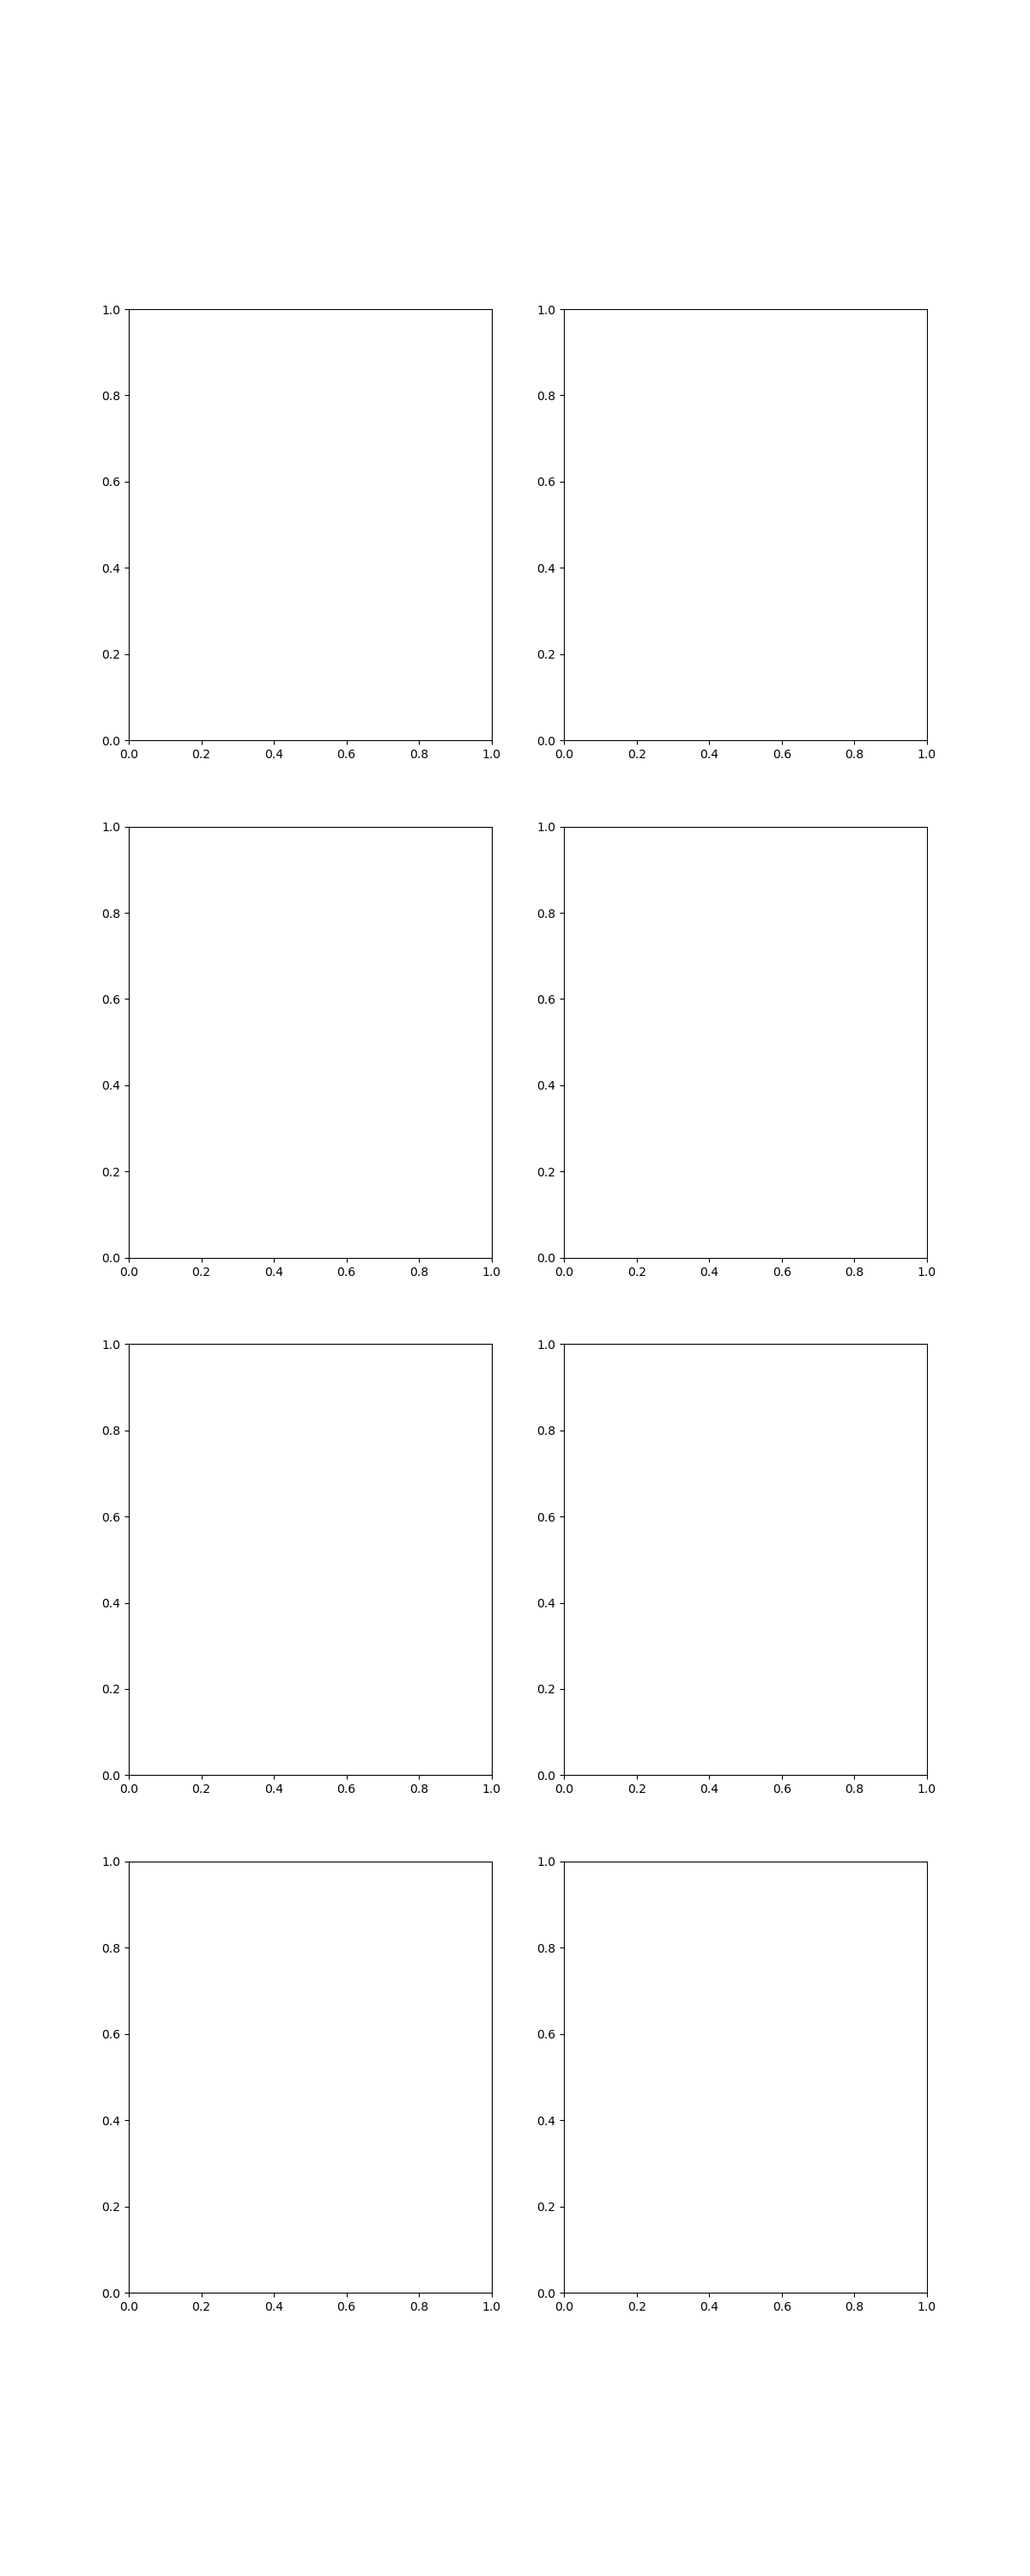

In [817]:
explanatory_raster_list = [window_cropped_compare_slope,window_cropped_compare_roughness,window_cropped_compare_aspect,window_cropped_compare_chm]
labels = ["Topo diff NMAD (50m window)","Topo diff median (50m window)","Topo diff mean (50m window)","Topo diff variance (50m window)", "Slope median (50m window)","Roughness median (50m window)","Aspect median (50m window)","Canopy height median (50m window)"]
# Open the raster file
with rasterio.open(window_cropped_topo_diff) as src:
    window_topo_diff_data_nmad = src.read(1, masked=True)
    window_topo_diff_data_median = src.read(2, masked=True)
    window_topo_diff_data_mean = src.read(3, masked=True)
    window_topo_diff_data_var = src.read(5, masked=True)

explanatory_datasets = [window_topo_diff_data_nmad,window_topo_diff_data_median,window_topo_diff_data_mean,window_topo_diff_data_var]
for i, raster in enumerate(explanatory_raster_list):
    with rasterio.open(raster) as src:
        data_median = src.read(2, masked=True)
        explanatory_datasets.append(data_median)

# Create a figure with 5 subplots arranged vertically
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 30))  # Adjust figsize as needed

# Loop through the axes to plot each subplot
for i, ax in enumerate(axes):
    # Use the same raster data for demonstration; you can replace with different data for each subplot if necessary
    im = ax.imshow(explanatory_datasets[i], cmap='gnuplot')
    
    # Create a colorbar for each subplot and associate it with the mappable object
    fig.colorbar(im, ax=ax, label=labels[i])

    # Optional: set titles for each subplot for clarity
    ax.set_title(f"Subplot {i+1}")

# Display the figure with all subplots
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

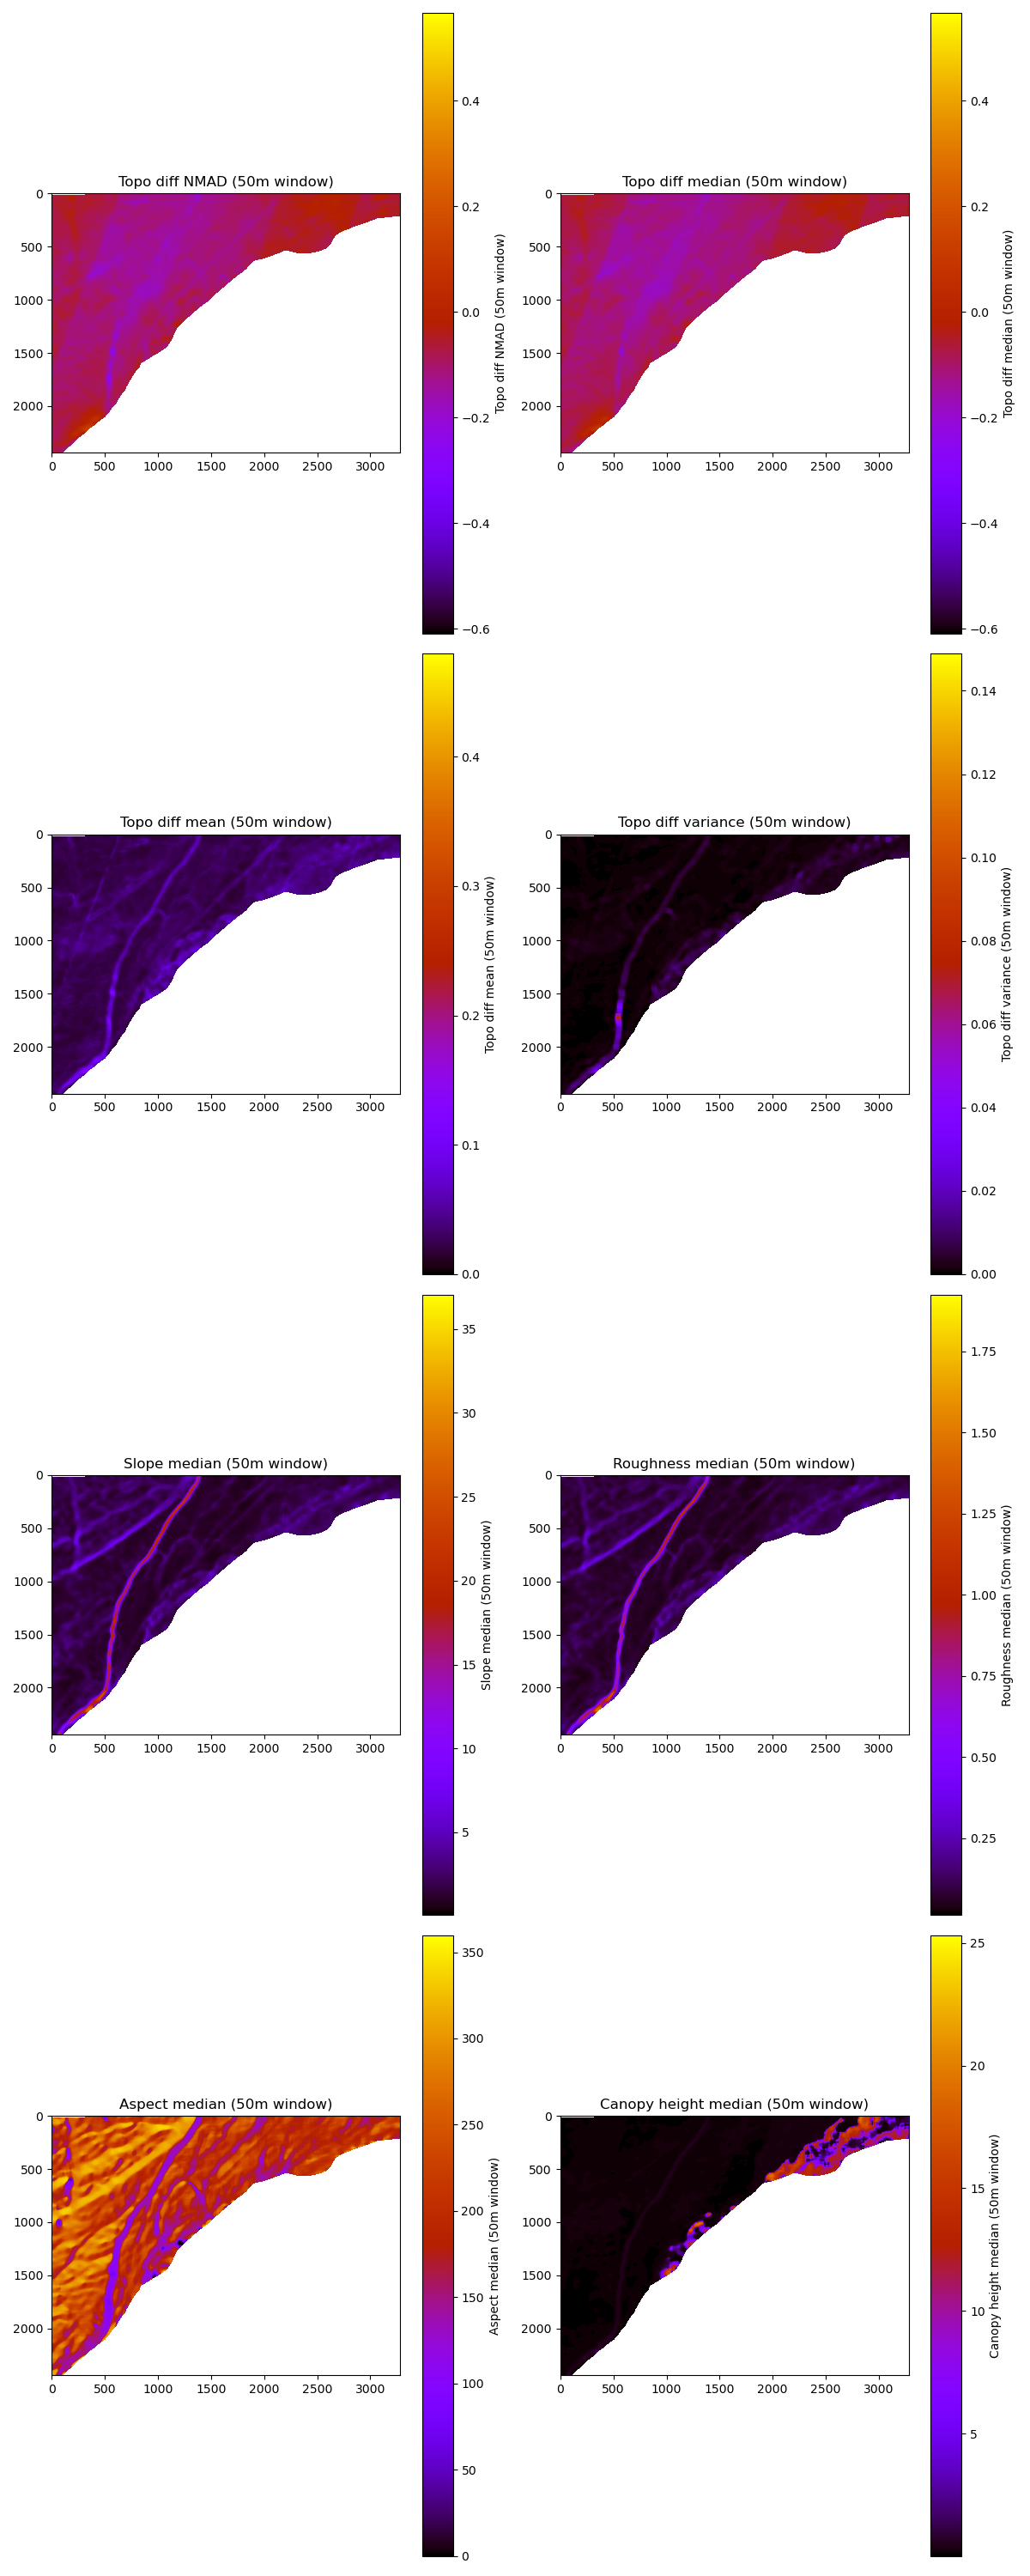

In [822]:
import matplotlib.pyplot as plt
import rasterio

# Assuming your lists of rasters and labels are already defined

# Read data from raster files
explanatory_datasets = []
with rasterio.open(window_cropped_topo_diff) as src:
    explanatory_datasets.append(src.read(1, masked=True))  # NMAD
    explanatory_datasets.append(src.read(2, masked=True))  # Median
    explanatory_datasets.append(src.read(3, masked=True))  # Mean
    explanatory_datasets.append(src.read(5, masked=True))  # Variance

# Read additional data from other rasters
for raster in explanatory_raster_list:
    with rasterio.open(raster) as src:
        explanatory_datasets.append(src.read(2, masked=True))  # Median values from other rasters

# Create a figure with 8 subplots arranged in 4x2 grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 30))  # Adjust figsize as needed

# Loop through the axes to plot each subplot
for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array to easily iterate over it
    # Display the data using imshow on each Axes object
    im = ax.imshow(explanatory_datasets[i], cmap='gnuplot')
    
    # Create a colorbar for each subplot and associate it with the mappable object
    fig.colorbar(im, ax=ax, label=labels[i])

    # Set titles for each subplot for clarity
    ax.set_title(labels[i])

# Adjust layout to fit everything nicely
plt.tight_layout()
plt.show()

## Plot relationship between spread in differencing results and potential explanatory variables

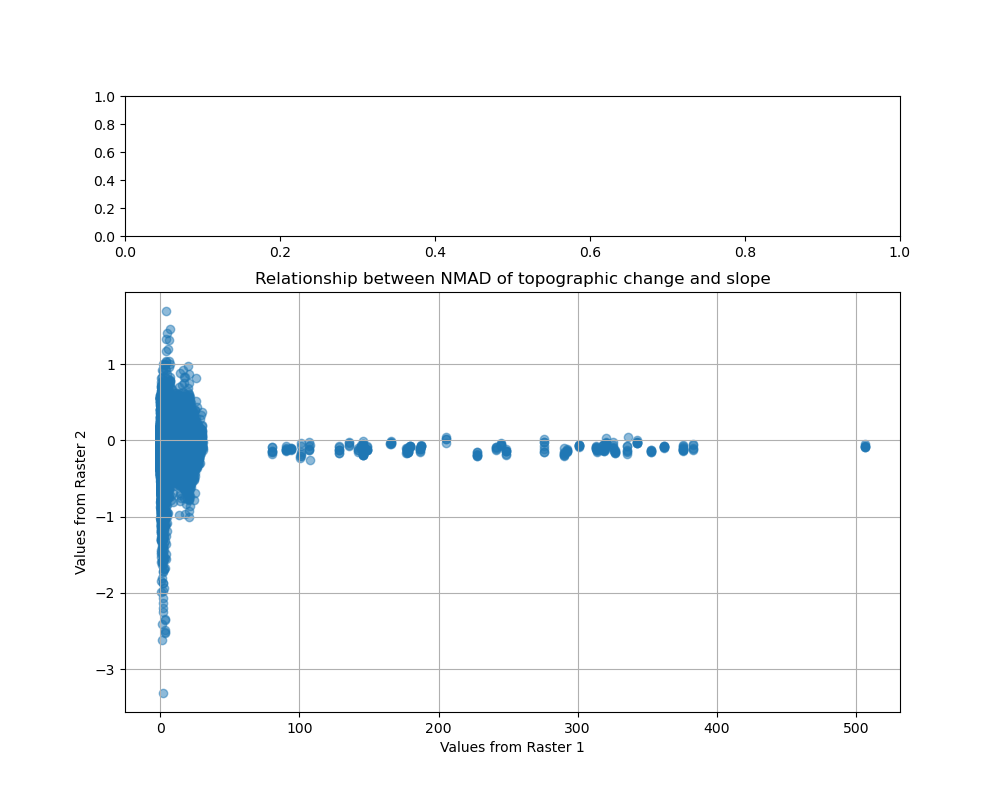

In [837]:
# Open the rasters
raster1_path = cropped_compare_chm
raster2_path =cropped_topo_diff

raster1_ds = gdal.Open(raster1_path)
raster2_ds = gdal.Open(raster2_path)

# Read data from the first band of each raster
band1_raster1 = raster1_ds.GetRasterBand(1).ReadAsArray()
band1_raster2 = raster2_ds.GetRasterBand(1).ReadAsArray()

# Optionally, mask no data values if they are specified and could interfere with correlation
no_data_value_raster1 = raster1_ds.GetRasterBand(1).GetNoDataValue()
no_data_value_raster2 = raster2_ds.GetRasterBand(1).GetNoDataValue()

if no_data_value_raster1 is not None:
    band1_raster1 = np.ma.masked_equal(band1_raster1, no_data_value_raster1)
if no_data_value_raster2 is not None:
    band1_raster2 = np.ma.masked_equal(band1_raster2, no_data_value_raster2)
    
x = band1_raster1.flatten()
y = band1_raster2.flatten()

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 8))
ax[1].scatter(x, y, alpha=0.5)  # Alpha is used to handle overplotting
plt.title('Relationship between NMAD of topographic change and slope')
plt.xlabel('Values from Raster 1')
plt.ylabel('Values from Raster 2')
plt.grid(True)
plt.show()

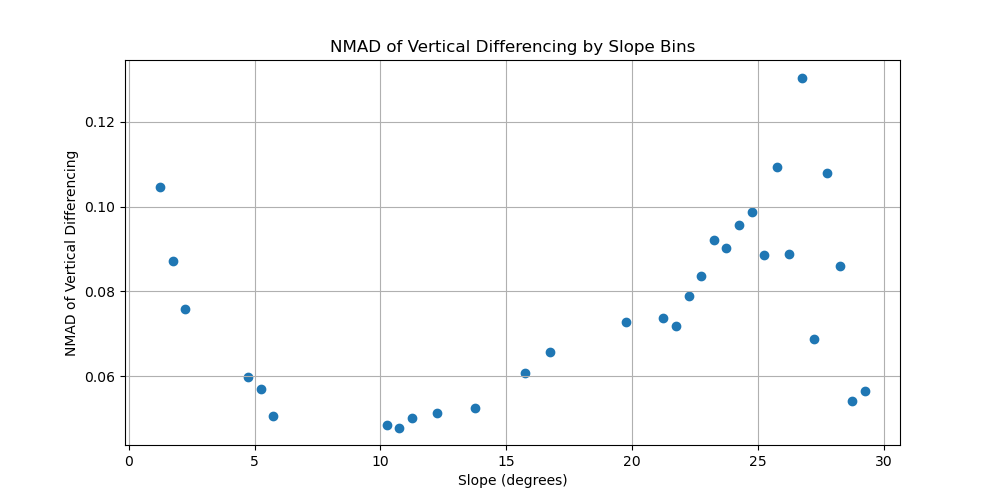

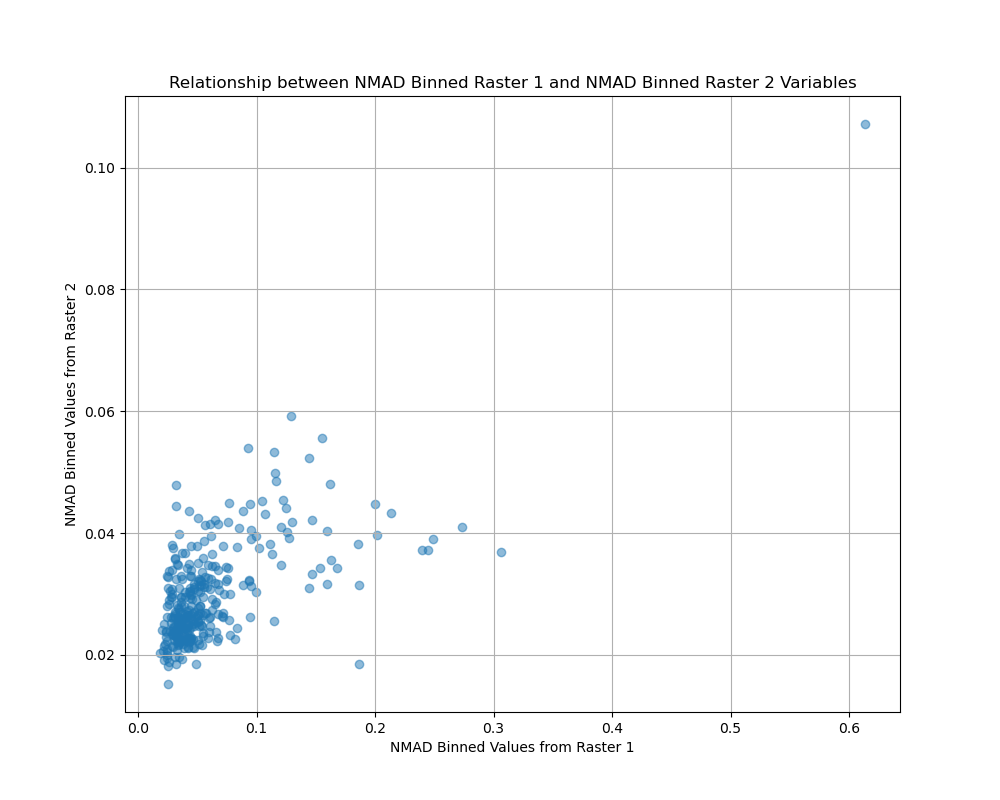

In [659]:
bin_size = 100 # Define the bin size

# Apply the NMAD binning function
binned_raster1 = bin_raster_data_nmad(band1_raster1, bin_size)
binned_raster2 = bin_raster_data_nmad(band1_raster2, bin_size)
x_binned = binned_raster1.flatten()
y_binned = binned_raster2.flatten()


fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 8))
ax[0].
ax[1].scatter(x, y, alpha=0.5)  # Alpha is used to handle overplotting
plt.figure(figsize=(10, 8))
plt.scatter(x_binned, y_binned, alpha=0.5)
plt.title('Relationship between NMAD Binned Raster 1 and NMAD Binned Raster 2 Variables')
plt.xlabel('NMAD Binned Values from Raster 1')
plt.ylabel('NMAD Binned Values from Raster 2')
plt.grid(True)
plt.show()

## Polynomial regression

### Fit model

In [847]:
# Load the differencing results and other variables
chm_data, chm_nodata = load_raster_data(window_cropped_compare_chm)
slope_data, slope_nodata = load_raster_data(window_cropped_compare_slope)
roughness_data, roughness_nodata = load_raster_data(window_cropped_compare_roughness)
aspect_data, aspect_nodata = load_raster_data(window_cropped_compare_aspect)
topo_diff_data, topo_diff_nodata = load_raster_data(window_cropped_topo_diff)

#X = valid_data_raster(slope_data, slope_nodata, roughness_data, roughness_nodata, aspect_data, aspect_nodata, chm_data, chm_nodata, topo_diff_data, topo_diff_nodata)
X = valid_data_raster(slope_data, slope_nodata, chm_data, chm_nodata, topo_diff_data, topo_diff_nodata)

# Assuming topo_diff_data is your target variable (y)
#y = topo_diff_data[np.logical_and.reduce([(arr != nodata) & ~np.isnan(arr) for arr, nodata in zip([slope_data, roughness_data, aspect_data, chm_data, topo_diff_data], [slope_nodata, roughness_nodata, aspect_nodata, chm_nodata, topo_diff_nodata])])]
y = topo_diff_data[np.logical_and.reduce([(arr != nodata) & ~np.isnan(arr) for arr, nodata in zip([slope_data, chm_data, topo_diff_data], [slope_nodata, chm_nodata, topo_diff_nodata])])]


X = X[:-1].T  # Exclude the target variable from X

# Confirm that there are no NaN values
assert not np.isnan(X).any(), "NaN values found in predictor variables (X)"
assert not np.isnan(y).any(), "NaN values found in target variable (y)"

# Fit polynomial regression to the data
degree = 3 # You can adjust the degree of the polynomial based on model fit and complexity considerations
model = Pipeline([
    #('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)),
    ('linear', LinearRegression(fit_intercept=True))
])
model.fit(X, y)

# Predict using the trained model
y_pred = model.predict(X)

# Calculate metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.0010172418551519513
R-squared: 0.29130180546505535


### Interpolate polynomial function and save raster

In [849]:
# Dictionary of feature rasters used during model training
raster_paths = {
    'slope': cropped_compare_slope,
    #'roughness': cropped_compare_roughness,
    #'aspect': cropped_compare_aspect,
    'canopy_height': cropped_compare_chm,
    # Add more features as required
}

input_raster_path = cropped_topo_diff

# Generate grid and predict values
X, Y, crs, transform, width, height = generate_grid(input_raster_path)
predictions = predict_values(X, Y, model, raster_paths)

interpolated_poly_raster = data_path+"interpolated.tif"

# Create and save the raster of predictions
create_raster(interpolated_poly_raster, predictions, crs, transform, width, height)

In [672]:
with rasterio.open(interpolated_poly_raster, 'r+') as src:
    # For a single-band raster:
    band_number = 1  # Adjust the band number as needed
    data = src.read(band_number)
    # Replace the values
    data[data <= -9999] = -9999
    data[data >= 9999] = -9999
    
    no_data_value = -9999
    
    src.nodata = no_data_value
    
    data[data == src.nodata] = no_data_value
    
    src.write(data, band_number)
    
interpolated_rio = rio.open_rasterio(interpolated_poly_raster, masked=True)

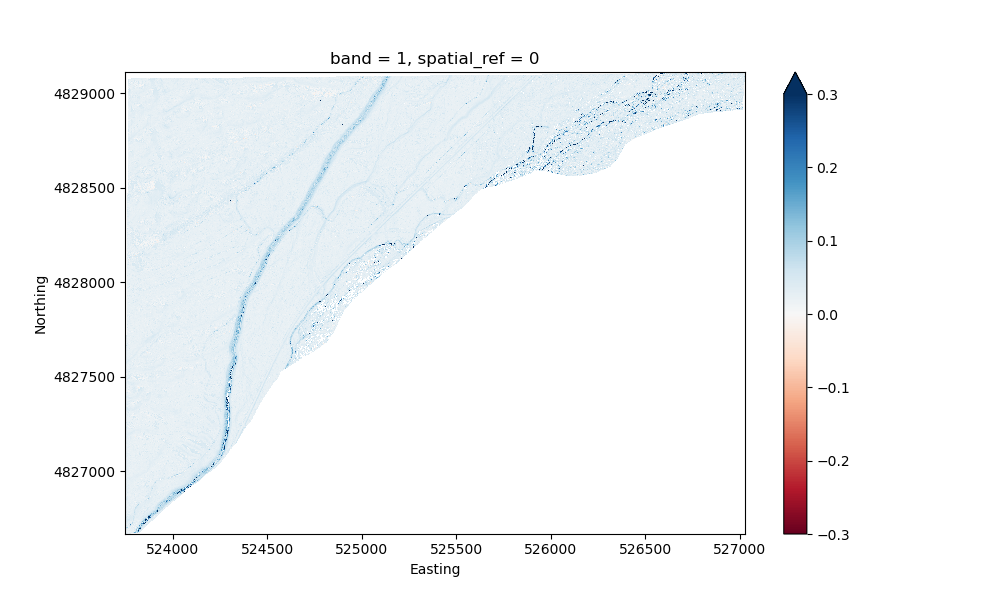

In [673]:
fig,ax=plt.subplots(figsize=(10, 6))
interpolated_rio.plot(ax=ax,cmap="RdBu", vmin=-0.3,vmax=0.3,robust=True)
#ax.set_title("Topographic change between compare and reference datasets (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

In [691]:
cropped_topo_diff_rio = rio.open_rasterio(cropped_topo_diff, masked=True) 


interpolated_rio = interpolated_rio.assign_coords({
    "x": cropped_topo_diff_rio.x,
    "y": cropped_topo_diff_rio.y,
})

diff_interpolated_rio = cropped_topo_diff_rio / interpolated_rio
diff_interpolated_rio.compute()


diff_interpolated_rio.rio.to_raster(diff_interpolated_raster)

In [712]:
diff_interpolated_raster = data_path+"diff_interpolated.tif"
# Open the first raster
with rasterio.open(cropped_topo_diff) as src1:
    data1 = src1.read(1)  # Read the first band
    meta = src1.meta  # Metadata to use for the output raster

# Open the second raster
with rasterio.open(interpolated_poly_raster) as src2:
    data2 = src2.read(1)  # Read the first band

# Define no-data value (assuming both rasters have the same no-data value)
no_data = meta['nodata']

# Safely perform division, ignoring divisions by zero or where no-data is involved
result = np.where((data2 == no_data) | (data1 == no_data), no_data, data1 / data2)

# Update metadata for the new raster (if necessary, adjust dtype based on your needs)
meta.update(dtype=rasterio.float32, nodata=no_data)

# Write the result to a new raster file
with rasterio.open(diff_interpolated_raster, 'w', **meta) as dst:
    dst.write(result, 1)

In [714]:
result[result>-9999]

array([16.52919451, -5.65912293, -8.63577145, ..., -3.42230561,
       -3.87407319, -4.19481877])

In [706]:
diff_interpolated,diff_interpolated_nodata = load_raster_data(diff_interpolated_raster)

In [711]:
diff_interpolated_nodata

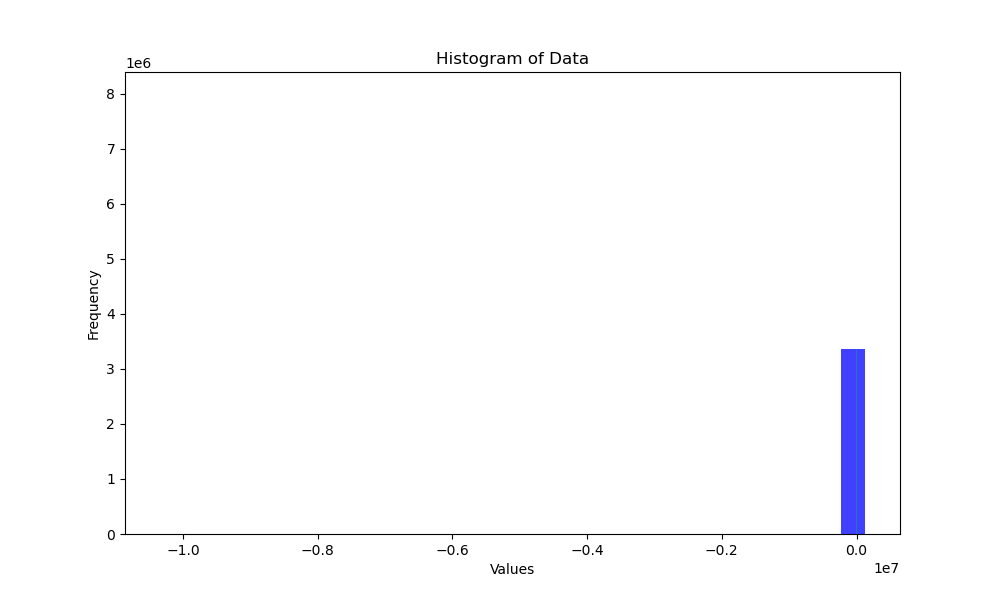

In [728]:
plt.hist(topo_diff_data)
plt.show()


In [722]:
result[result>-9999]

array([16.52919451, -5.65912293, -8.63577145, ..., -3.42230561,
       -3.87407319, -4.19481877])

In [717]:
len(result[result>-9999])

3362879

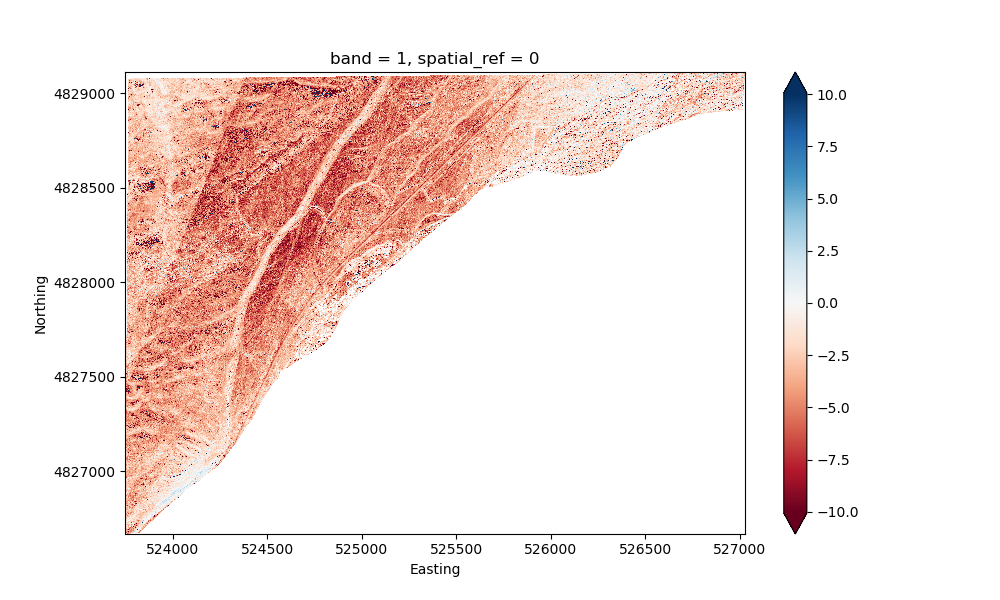

In [692]:
fig,ax=plt.subplots(figsize=(10, 6))
diff_interpolated_rio.plot(ax=ax,cmap="RdBu", robust=True)
#ax.set_title("Topographic change between compare and reference datasets (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

(array([1.200000e+01, 3.660000e+02, 7.997377e+06, 1.650000e+02,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

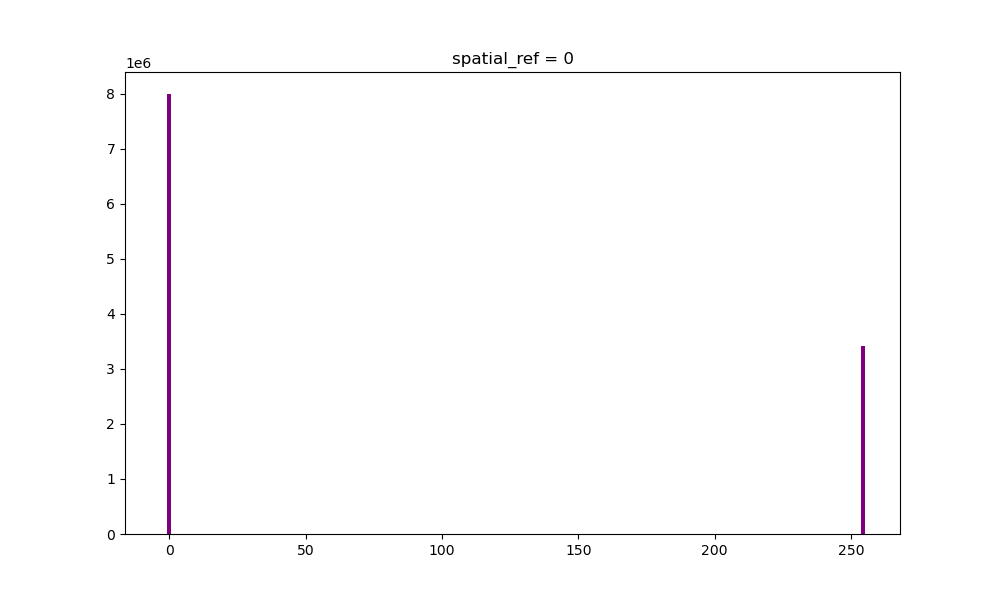

In [704]:
dtm_pre_arr = rio.open_rasterio(cropped_topo_diff , masked=True)
f, ax = plt.subplots(figsize=(10, 6))
dtm_pre_arr.plot.hist(color="purple",
                      bins=200)


In [705]:
dtm_pre_arr

<xarray.DataArray (band: 2, y: 2441, x: 3282)> Size: 128MB
array([[[          nan,           nan, ..., -7.550415e-02, -5.989788e-02],
        [          nan,           nan, ..., -4.749305e-02, -8.159901e-02],
        ...,
        [-8.053296e-02, -7.616250e-02, ...,           nan,           nan],
        [-7.099093e-02, -6.823072e-02, ...,           nan,           nan]],

       [[ 0.000000e+00,  0.000000e+00, ...,  2.550000e+02,  2.550000e+02],
        [ 0.000000e+00,  0.000000e+00, ...,  2.550000e+02,  2.550000e+02],
        ...,
        [ 2.550000e+02,  2.550000e+02, ...,  0.000000e+00,  0.000000e+00],
        [ 2.550000e+02,  2.550000e+02, ...,  0.000000e+00,  0.000000e+00]]])
Coordinates:
  * band         (band) int64 16B 1 2
  * x            (x) float64 26kB 5.237e+05 5.237e+05 ... 5.27e+05 5.27e+05
  * y            (y) float64 20kB 4.829e+06 4.829e+06 ... 4.827e+06 4.827e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

# Estimate systematic error

### Extract differencing data along profiles

#### Function

In [729]:
def interpolate_line(line, distance):
    """
    Create points at specified intervals along a line.

    Parameters:
    - line (LineString): The LineString to interpolate.
    - distance (float): The distance between points.

    Returns:
    - list: List of Point geometries along the line.
    """
    num_segments = int(line.length / distance)
    points = [line.interpolate(distance * i) for i in range(num_segments + 1)]
    return points

def calculate_cumulative_distance(points):
    """
    Calculate the cumulative distance along a path defined by a list of shapely points.

    Parameters:
    - points (list of shapely.geometry.Point): The list of points defining the path.

    Returns:
    - list: A list of cumulative distances where each index corresponds to the distance from
            the start to the point at that index.
    """
    if not points:
        return []

    # Initialize the list of distances with the first distance as 0 (since it's the starting point)
    cumulative_distances = [0.0]

    # Iterate over the list of points and calculate distances
    for i in range(1, len(points)):
        # Calculate distance from the previous point
        distance = points[i].distance(points[i - 1])
        # Add this distance to the last cumulative distance in the list
        cumulative_distances.append(cumulative_distances[-1] + distance)

    return cumulative_distances

#### Usage

In [516]:
# Get raster resolution
with rasterio.open(diff_interpolated_raster) as src:
    res = src.res[0] 
    
#Interpolate points along the Linestrings at that resolution

points = {}

for i, profile in enumerate(profiles):
    line = profiles[profile]['geometry'][0]

    key = f"{profile}"
        
    points[key] = interpolate_line(line, res)

In [517]:
raster_values = {}
unique_points = {}
with rasterio.open(diff_interpolated_raster) as src:  
# Get the transformation object from the dataset
    transform = src.transform  
    for i, point in enumerate(points):
        
        list_point = points[f"{point}"]

        # Transform the points into raster space coordinates
        raster_space_coords = [src.index(p.x, p.y) for p in list_point]

        # Remove duplicate coordinates and read the values
        #unique_coords = list(set(raster_space_coords))  # Remove duplicates to avoid multiple readings of the same cell
        
        values_temp = [src.read(1)[coord[1], coord[0]] for coord in raster_space_coords if 0 <= coord[0] < src.width and 0 <= coord[1] < src.height]
        
        # Convert raster space coordinates back to geographical coordinates using the affine transform
        #geo_coords = [transform * (coord[0], coord[1]) for coord in unique_coords]

        key = f"{point}"
        
        # Convert geographical coordinates to Shapely points
        #unique_points[key] = [Point(xy) for xy in geo_coords]
        
        raster_values[key] = values_temp

In [518]:
distances = {}
for i, point in enumerate(points):
     list_point = points[f"{point}"]
     
     distance = calculate_cumulative_distance(list_point)
     
     key = f"{point}"
            
     distances[key] = distance

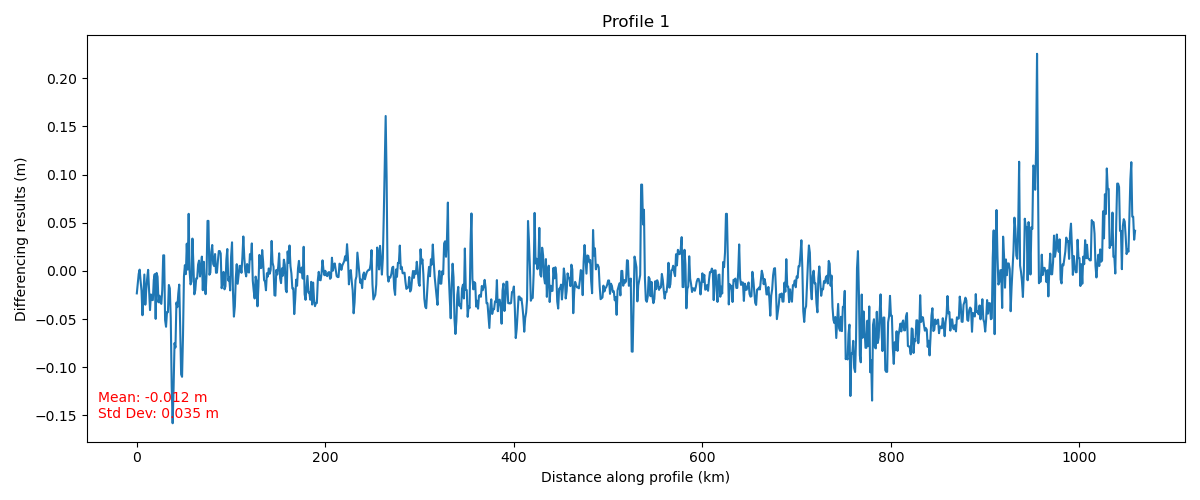

In [519]:
n_profiles = len(profiles.keys())

# Create a grid of subplots
fig, axes = plt.subplots(n_profiles, 1, figsize=(12, n_profiles * 5), sharex=False) 

if n_profiles == 1:
    axes = [axes]

# Plot each profile in a separate subplot
for i, ax in enumerate(axes):
    # Filter data for the current profile
    keys = list(points.keys())
    profile_diff = raster_values[keys[i]]
    profile_distance = distances[keys[i]]
    
    # Calculate mean and standard deviation
    mean_val = np.mean(profile_diff)
    std_val = np.std(profile_diff)
    
    # Use Seaborn to plot
    sns.lineplot(ax=ax, x=profile_distance, y=profile_diff, linestyle='-')
    ax.set_title(f'Profile {i + 1}')
    ax.set_ylabel('Differencing results (m)')
    ax.set_xlabel('Distance along profile (km)')

    # Display the mean and standard deviation on the plot
    ax.text(0.01, 0.05, f'Mean: {mean_val:.3f} m\nStd Dev: {std_val:.3f} m', transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='left', fontsize=10, color='red')

plt.tight_layout()
plt.show()

### Remove estimated systematic error from differencing results

# Estimate correlated error

## Variography

### Functions

In [694]:
def clip_rasters_by_polygons(raster_path, polygons, output_dir):
    """
    Clips a raster into multiple rasters based on a list of Shapely polygons with error handling for non-overlapping polygons.

    Parameters:
    - raster_path (str): Path to the input raster.
    - polygons (list of shapely.geometry.Polygon): List of polygon geometries to clip the raster.
    - output_dir (str): Directory where the clipped rasters will be saved.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Open the raster
    with rasterio.open(raster_path) as src:
        for i, poly in enumerate(polygons):
            # Convert the polygon into GeoJSON format
            geo = [mapping(poly)]

            try:
                # Perform the clipping
                out_image, out_transform = mask(src, geo, crop=True, all_touched=True)

                if out_image.size == 0:
                    raise ValueError("The polygon does not overlap with the raster or results in an empty raster.")

                # Update the metadata of the raster
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                # Save the resulting raster
                out_raster_path = os.path.join(output_dir, f"stable_raster_{i+1}.tif")
                with rasterio.open(out_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)
            
            except Exception as e:
                print(f"Failed to clip raster with polygon index {i}: {e}")

def sample_raster(raster, samples_per_sq_km, max_samples):
    """
    Samples the raster data based on a given density (samples per square kilometer) and a maximum number of samples to limit analysis time.
    Returns the sampled values and their corresponding coordinates, with no data values represented as NaN.

    Parameters:
    -----------
    samples_per_sq_km : int
        The desired number of samples per square kilometer.
    max_samples : int
        The maximum number of samples to be taken.

    Returns:
    --------
    samples : numpy.ndarray
        An array of sampled vertical differencing values (in m) from the raster data, with NaN for no data values.
    coords : numpy.ndarray
        The coordinates corresponding to each sampled value.
    """
    with rasterio.open(raster) as src:
        data = src.read(1)  # Read the first band
        nodata = src.nodata  # Get the nodata value from the raster

        # Replace nodata values with NaN in the numpy array
        data = np.where(data == nodata, np.nan, data)

        # Create a mask where data is not NaN (valid data points)
        valid_data_mask = ~np.isnan(data)
        
        cell_size, cell_area_sq_km = src.res[0], (src.res[0] ** 2) / 1e6
        valid_data_points = np.sum(valid_data_mask)
        
        # Calculate total number of samples based on area and sample density, without exceeding the number of valid data points
        total_samples = min(int(cell_area_sq_km * samples_per_sq_km * valid_data_points), max_samples)

        if total_samples > valid_data_points:
            raise ValueError("Requested samples exceed valid data points.")
        
        # Randomly choose indices from the valid data points
        chosen_indices = np.random.choice(np.where(valid_data_mask.ravel())[0], size=total_samples, replace=False)
        
        # Extract samples and coordinates for the chosen indices
        samples = data.ravel()[chosen_indices]
        coords = np.array([src.xy(index // data.shape[1], index % data.shape[1]) for index in chosen_indices])

        return samples, coords


In [756]:
class VariogramAnalysis:
    """
    A class to perform variogram analysis on raster data. It calculates mean variograms, 
    fits spherical models to the variogram data, and plots the results.

    Attributes:
    -----------
    mean_variogram : numpy.ndarray
        The mean variogram calculated from multiple runs.
    lags : numpy.ndarray
        The distances (lags) at which the variogram is calculated.
    mean_count : numpy.ndarray
        The mean count of data pairs used for each lag distance.
    err_variogram : numpy.ndarray
        The standard deviation of the variogram values across multiple runs.
    fitted_variogram : numpy.ndarray
        The variogram values fitted using a model.
    rmse : float
        The root mean square error of the fitted model.
    sills : list
        The sill values of the fitted spherical model components.
    ranges : list
        The range values of the fitted spherical model components.
    err_param : numpy.ndarray
        The standard error of the parameters of the fitted model.
    initial_guess : list
        The initial guess parameters for the fitting process.

    Methods:
    --------
    calculate_mean_variogram(n_bins, n_runs)
        Calculates the mean variogram and its error from multiple runs.
    plot_3_spherical_models_no_nugget()
        Plots the mean variogram and its error
    """
    def __init__(self):
       
        self.mean_variogram = None
        self.lags = None
        self.mean_count = None
        self.err_variogram = None
        self.fitted_variogram = None
        self.rmse_filtered = None
        self.rmse = None
        self.sills = None
        self.ranges = None
        self.err_param = None
        self.err_ranges = None
        self.err_sills = None
        self.initial_guess = None
        self.ranges_min = None
        self.ranges_max = None
        self.sills_min = None
        self.sills_max = None
        self.list_models = None
        self.model_combinations = None
        self.model_functions = None
        self.model_defaults = None
        self.all_popt = None
        self.all_pcov = None
        self.all_params = None
        self.all_rmse = None
        self.all_y_pred = None
        
    def calculate_mean_variogram(self, list_raster, n_bins, n_runs):
        """
        Calculates the mean variogram and its error from multiple sampling and calculation runs.

        Parameters:
        -----------
        n_bins : int
            The number of bins to divide the distance range into for variogram calculation.
        n_runs : int
            The number of runs to perform for sampling and variogram calculation.
        """
        all_variograms = np.zeros((n_runs, n_bins-1))  
        bin_widths = np.zeros(1)
        min_distances = np.zeros(1)
        max_distances = np.zeros(1)
        counts = np.zeros((n_runs, n_bins-1))

        for run in range(n_runs):
            samples = []
            coords = []
            for raster in list_raster:
                # Sample raster
                samples_temp, coords_temp = sample_raster(raster,1000,100000)
                samples.append(samples_temp)
                coords.append(coords_temp)
            
            if run == 0:
                bin_width, min_distance, max_distance = variogram_tools.calculate_bin_width_multiple(coords, n_bins)
                # Calculate variogram for this run
                variogram, count = variogram_tools.dowd_estimator_multiple_cy(coords, samples, n_bins, bin_width, min_distance, max_distance)
                # Store the results
                all_variograms[run, :] = variogram
                counts[run, :] = count
                bin_widths[run] = bin_width
                min_distances[run] = min_distance
                max_distances[run] = max_distance
            else:
                # Calculate variogram for this run
                variogram, count = variogram_tools.dowd_estimator_multiple_cy(coords, samples, n_bins, bin_widths[0], min_distances[0], max_distances[0])
                # Store the results
                all_variograms[run, :] = variogram
                counts[run, :] = count
                
        # Calculate mean and std dev of variograms across all runs
        self.mean_variogram = np.mean(all_variograms, axis=0)
        self.mean_count = np.mean(counts, axis=0)
        self.err_variogram = np.std(all_variograms, axis=0)
        
        # Assuming bin_widths are similar across runs, use the first one to calculate bin lags
        self.lags = np.linspace(min_distances[0] + bin_widths[0] / 2, max_distances[0] - bin_widths[0] / 2, n_bins - 1)
    
    @staticmethod
    def gaussian(h, sill, range):
        return sill * (1 - np.exp(- (h ** 2) / (2 * range ** 2)))

    @staticmethod
    def spherical(h, sill, range):
        return np.where(h <= range, sill * (1.5 * h / range - 0.5 * (h / range) ** 3), sill)

    @staticmethod
    def hole_effect(h, sill, range):
        return sill * (1 - np.cos(2 * np.pi * h / range))

    @staticmethod
    def matern(h, sill, range, nu):
        part1 = 2 ** (1 - nu) / gamma(nu)
        part2 = (h / range) ** nu
        part3 = kv(nu, h / range)
        return sill * (1 - part1 * part2 * part3)

    @staticmethod
    def exponential(h, sill, range):
        return sill * (1 - np.exp(- h / range))

    @staticmethod
    def power(h, scale, exponent):
        return scale * h ** exponent

    @staticmethod
    def linear(h, slope):
        return slope * h

    @staticmethod
    def logarithmic(h, scale):
        # Avoid log(0) by replacing zero distances with a very small value
        h = np.where(h == 0, 1e-50, h)
        return scale * np.log(h)

    @staticmethod
    def noop(h, *args, **kwargs):
        """Function for 'None' model, which does nothing."""
        return np.zeros_like(h)
    
    def define_model(self, number_of_models):
        #self.list_models=["gaussian","hole-effect","matern","exponential","spherical","power","linear","logarithmic","None"]
        #self.list_models=["gaussian","matern","exponential","spherical","power","linear","logarithmic","None"]
        self.list_models=["gaussian","matern","exponential","spherical","hole-effect","None"]

        self.model_combinations = list(combinations_with_replacement(self.list_models, number_of_models))

        self.model_functions = {
            "gaussian": self.gaussian,
            "hole-effect": self.hole_effect,
            "matern": self.matern,
            "exponential": self.exponential,
            "spherical": self.spherical,
            "power": self.power,
            "linear": self.linear,
            "logarithmic": self.logarithmic,
            "None": self.noop,
            
        }

        self.model_defaults = {
            "gaussian": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "spherical": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "exponential": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "hole-effect": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "matern": {"params": ["sill", "range", "nu"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8, 0.5], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3), (0.1, 2)]},
            #"power": {"params": ["scale", "exponent"], "base_guess": [0.5, 1.5], "bounds": [(0, 1), (1, 2)]},  
            #"linear": {"params": ["slope"], "base_guess": [0.1], "bounds": [(0, 1)]},  
            #"logarithmic": {"params": ["scale"], "base_guess": [0.5], "bounds": [(0, 1)]},  
            "None": {"params": [], "base_guess": [], "bounds": []}
        }
        
    def adjust_range_based_on_order(self, combination):
        """
        Adjusts initial guesses and bounds for model parameters based on their order in the combination.
        Specifically, the range parameters are adjusted to increase depending on their position.
        
        Parameters:
        - model_defaults: Dictionary with model configurations.
        - combination: List of model names in the combination.
        
        Returns:
        - Tuple of (initial_guesses, bounds) for the combination.
        """
        initial_guesses = []
        bounds_lower = []
        bounds_upper = []
        range_multiplier = 1
        params=[]
        
        for model_name in combination:
            model = self.model_defaults[model_name]
            if model_name != "None":
                # Adjust range based on its order among models with a range parameter
                base_guess = np.array(model["base_guess"])
                params_ = model["params"]
                if "range" in model["params"]:
                    base_guess[model["params"].index("range")] *= range_multiplier
                    range_multiplier += 1  # Prepare for the next model with a range
                
                # Append adjusted base guesses
                initial_guesses.extend(base_guess)

                params.append(params_)
                
                # Append bounds directly (adjustment for range bounds is not specified but could be added similarly)
                model_bounds = model["bounds"]
                bounds_lower.extend([bound[0] for bound in model_bounds])
                bounds_upper.extend([bound[1] for bound in model_bounds])

        # Combine lower and upper bounds into a list of tuples
        bounds = (bounds_lower, bounds_upper)

        return initial_guesses, bounds, params
    
    def summed_model(self,h, *params,combination_sequence):
        variogram_sum = np.zeros_like(h)
        param_index = 0  # Tracks the current index in the flat parameter list

        for model_name in combination_sequence:
            if model_name == "None":
                continue

            num_params = len(self.model_defaults[model_name]["params"])  # Get number of parameters required by the model
            model_params = params[param_index:param_index + num_params]  # Extract params for the current model

            # Call the model function with extracted parameters
            model_func = self.model_functions[model_name]
            variogram_sum += model_func(h, *model_params)

            param_index += num_params  # Move to the next segment of parameters for the next model

        return variogram_sum
    
    def get_rmse_and_params(self):
        all_popt = []
        all_pcov = []
        all_params = []
        all_rmse = []
        all_y_pred = []
        
        #weights=self.err_variogram#/self.mean_count
        weights=self.err_variogram
        weights=np.where(weights == 0, 1.1111e-50,weights)

        for combo in self.model_combinations[:-1]:
            try:
                initial_guesses, bounds, params = self.adjust_range_based_on_order(combo)
                all_params.append(params)

                # Adjusted curve_fit call within a try-except block
                popt, pcov = curve_fit(
                lambda h, *params: self.summed_model(h, *params, combination_sequence=combo),
                self.lags, self.mean_variogram, p0=initial_guesses, bounds=bounds, maxfev=10000, nan_policy='omit'
                )

                all_popt.append(popt)
                all_pcov.append(pcov)
                
                # Calculate RMSE for the current model and append to all_rmse
                y_pred = self.summed_model(self.lags, *popt, combination_sequence=combo)
                rmse = np.sqrt(np.mean((self.mean_variogram - y_pred) ** 2))
                all_rmse.append(rmse)
                all_y_pred.append(y_pred)

            except RuntimeError as e:
                print(f"Optimization failed for combination {combo}: {e}")
                # Append NaN to maintain alignment with model_combinations
                all_popt.append(np.nan)
                all_pcov.append(np.nan)
                all_rmse.append(np.nan)
                continue  # Proceed to the next iteration
        
        self.all_popt = all_popt
        self.all_pcov = all_pcov
        self.all_params = all_params
        self.all_rmse = all_rmse
        self.all_y_pred = all_y_pred
    
       
    def get_param_df(self,cof,combo):
        list_df = []
        i = 0
        for model in combo:
            # For models that expect 1 parameter
            if model in ["None"]:
                continue
            elif model in ["linear"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], slope=[cof[i]])
                i += 1
            elif model in ["logarithmic"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], scale=[cof[i]])
                i += 1
            # For models that expect 2 parameters
            elif model in ["spherical", "gaussian", "exponential", "hole-effect"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], psill=[cof[i]], range=[cof[i + 1]])
                i += 2
            elif model in ["power"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], scale=[cof[i]], exponent=[cof[i + 1]])
                i += 2
            # For models that expect 3 parameters
            elif model in ["matern"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], psill=[cof[i]], range=[cof[i + 1]], smooth=[cof[i + 2]])
                i += 3
            list_df.append(df)
    
        df_params = pd.concat(list_df).reset_index(drop=True)
        
        sum_model = self.summed_model(self.lags, *cof,combination_sequence=combo)
        
        return df_params, sum_model
    
    def plot_empirical_variogram(self):
        """
        Plots the mean variogram with error bars.
        """
        condition = self.mean_count > np.max(self.mean_count)/5 
        
        lags = self.lags#[condition]
        mean_variogram = self.mean_variogram#[condition]
        err_variogram = self.err_variogram#[condition]
        
        fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 8))

        # Histogram of semivariance counts
        ax[0].bar(self.lags, self.mean_count, width=np.diff(self.lags)[0]*0.9, color='orange', alpha=0.5)
        ax[0].set_ylabel('Mean Number\nof Pairs')

        # Plot mean variogram with error bars indicating spread over the 10 runs
        ax[1].errorbar(lags, mean_variogram, yerr=err_variogram, fmt='o-', color='blue', label='Mean Variogram with Spread')
       
        ax[1].set_xlabel('Lag Distance'), ax[1].set_ylabel('Semivariance')
        ax[1].legend()
        
        plt.setp(ax[0].get_xticklabels(), visible=False)
        plt.tight_layout()
        
        plt.show()

### Clip rasters

In [757]:
output_dir = data_path+"stable_rasters/"
polygons = [stable_areas[a]['geometry'][0] for a in stable_areas.keys()]

clip_rasters_by_polygons(diff_interpolated_raster, polygons, output_dir)

### Compute mean empirical variogram

In [758]:
list_rasters = [output_dir+filename for filename in os.listdir(output_dir) if filename.endswith('.tif') and "stable_raster" in filename]

#Create variogram analysis instance based on modified raster
V = VariogramAnalysis()

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram(list_rasters,75,10)

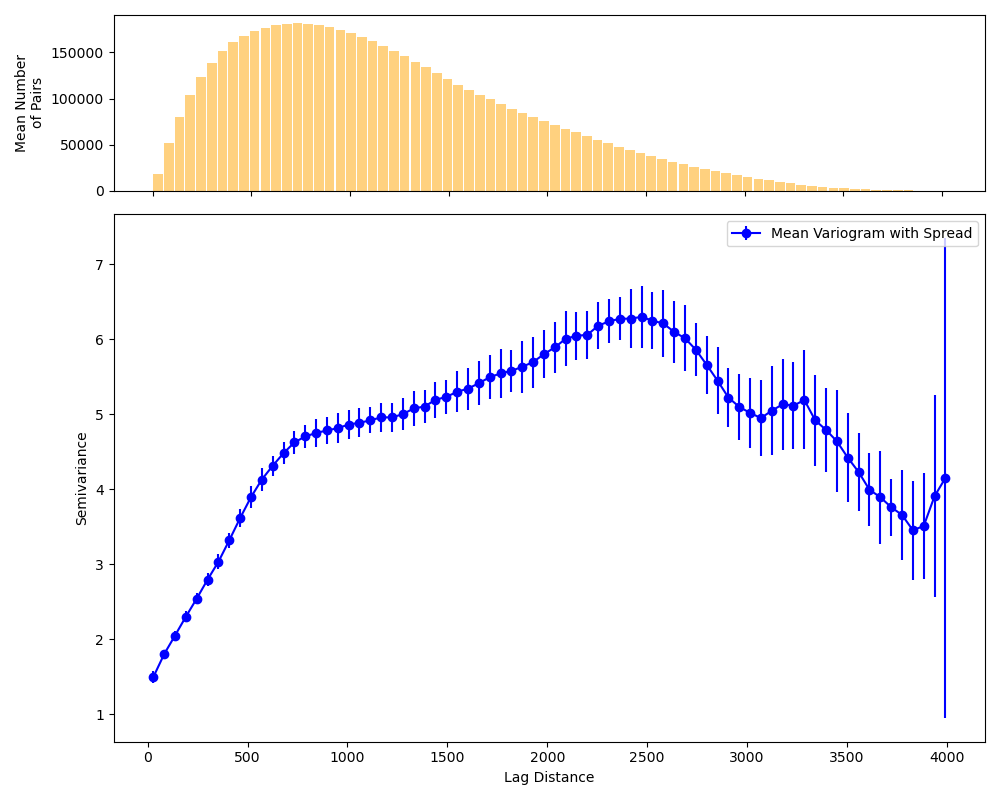

In [759]:
V.plot_empirical_variogram()

In [760]:
V.define_model(3)

V.get_rmse_and_params()

In [ ]:
min_rmse_models = V.model_combinations[np.nanargmin(np.array(V.all_rmse))]


In [ ]:
min_rmse_models 

('spherical', 'spherical', 'spherical')

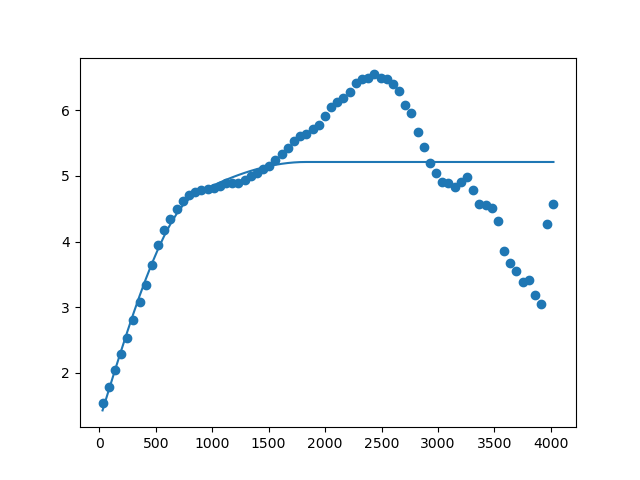

In [ ]:
fig,ax=plt.subplots()
ax.scatter(V.lags,V.mean_variogram)
ax.plot(V.lags,V.all_y_pred[np.nanargmin(np.array(V.all_rmse))])

In [ ]:
V.all_popt[np.nanargmin(np.array(V.all_rmse))]

array([1.26322240e+00, 2.63691428e+01, 2.56003672e+00, 8.56780772e+02,
       1.39046018e+00, 1.83115149e+03])

In [743]:
V.all_params[np.nanargmin(np.array(V.all_rmse))]

[['sill', 'range'], ['sill', 'range'], ['sill', 'range']]

In [744]:
combo = V.model_combinations[np.nanargmin(np.array(V.all_rmse))]
cof = V.all_popt[np.nanargmin(np.array(V.all_rmse))]
cov = V.all_pcov[np.nanargmin(np.array(V.all_rmse))]


In [745]:
a, b = V.get_param_df(cof,combo)

In [746]:
# Get total sill
total_sill = np.sum(a["psill"])

# Get function from sum of variogram
sum_variogram = b

def cov(total_sill,sum_variogram):
    return total_sill - sum_variogram

cov = cov(total_sill,sum_variogram)


In [747]:
def rho(cov, total_sill):
    return cov / total_sill

rho = rho(cov, total_sill)

In [748]:
rho

array([7.27143199e-01, 6.68370275e-01, 6.10212584e-01, 5.53075343e-01,
       4.97363770e-01, 4.43483084e-01, 3.91838503e-01, 3.42835244e-01,
       2.96878527e-01, 2.54373569e-01, 2.15725589e-01, 1.81339805e-01,
       1.51621435e-01, 1.26975697e-01, 1.07807810e-01, 9.45229918e-02,
       8.52514148e-02, 7.63894586e-02, 6.79016261e-02, 5.98092733e-02,
       5.21337565e-02, 4.48964319e-02, 3.81186557e-02, 3.18217841e-02,
       2.60271732e-02, 2.07561793e-02, 1.60301585e-02, 1.18704671e-02,
       8.29846123e-03, 5.33549707e-03, 3.00293083e-03, 1.32211870e-03,
       3.14416869e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      